# Transfer learning

Performance of neural model depends on a few factors but big points are: model architecture and quality of training. Both factors cost  computational power and the quality of the data set. In more complex problems, getting good accuracy can be difficult and resource intensive. 

Transfer learning is when take knowledge obtained from the completion of one task and implement it towards a second desired task that needs to be achieved. Ex: roller blader can pick up ice skating quickly because of similar skills in both activities. Similarly a nn can get one at one task and transfer its knoweldge to another related task. Though the tasks need to be similar to each other for transfer learning to be effective. 

Example, model that can monitor parked cars in the daytime can then be modified a little bit (minor training) to monitor during the night too. 

When to use trasfer learning: 
1. When you don't have enough labeled training data to train your model from scratch
2. An effective pre-trained model already exists

Looking at the MNIST and CIFAR datasets, they're relatively simiple compared to real life applications. Complex network architecutres can result in trainings that can take days, such a complex case will need to rely on transfer learning. 

How does transfer learning work? 
Pytorch and other libraries have built pre-trained models that have been trained and achieved good accuracy. 
1. AlexNet - feature section with 5 totall convolutional layers, 3 fully connected layers. input 240x240 images (much larger than what was used previously)
2. VGG16 - 24x224 input images. Larger than AlexNet, 13 convolutional layers with 3 fully connected layers = total of 16 layers. 

The dataset has 20000 images and many many classes. These models belong to the pytorch torchvision model library. And these two models are most popular.  

Going to use the feature extraction knowledge developed by the model. So the fully connected layers will change and adapt from the small dataset. Much faster than training model on the dataset from scratch. 

#### Lesson 1: Alexnet and VGG16

With transfer learning we can use a complex architecture still but bypass the long training time. 

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models 
#need to include models so we can have the pretrained models

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 2.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!ls #looking at what's in the folder

CIFAR10.ipynb                    linearRegression.ipynb
README.md                        numPy.ipynb
ants_and_bees                    perceptron.ipynb
convolutionalNeuralNetowrk.ipynb python.ipynb
data                             tensors.ipynb
deepNeuralNetworks.ipynb         transferLearning.ipynb
imageRecognition.ipynb


In [6]:
!ls ants_and_bees #looks like we have a training and validation set

train val


In [7]:
!ls ants_and_bees/train #going into the train folder

ants bees


In [8]:
!ls ants_and_bees/train/ants #these are all our images

0013035.jpg                   408393566_b5b694119b.jpg
1030023514_aad5c608f9.jpg     424119020_6d57481dab.jpg
1095476100_3906d8afde.jpg     424873399_47658a91fb.jpg
1099452230_d1949d3250.jpg     450057712_771b3bfc91.jpg
116570827_e9c126745d.jpg      45472593_bfd624f8dc.jpg
1225872729_6f0856588f.jpg     459694881_ac657d3187.jpg
1262877379_64fcada201.jpg     460372577_f2f6a8c9fc.jpg
1269756697_0bce92cdab.jpg     460874319_0a45ab4d05.jpg
1286984635_5119e80de1.jpg     466430434_4000737de9.jpg
132478121_2a430adea2.jpg      470127037_513711fd21.jpg
1360291657_dc248c5eea.jpg     474806473_ca6caab245.jpg
1368913450_e146e2fb6d.jpg     475961153_b8c13fd405.jpg
1473187633_63ccaacea6.jpg     484293231_e53cfc0c89.jpg
148715752_302c84f5a4.jpg      49375974_e28ba6f17e.jpg
1489674356_09d48dde0a.jpg     506249802_207cd979b4.jpg
149244013_c529578289.jpg      506249836_717b73f540.jpg
150801003_3390b73135.jpg      512164029_c0a66b8498.jpg
150801171_cd86f17ed8.jpg      512863248_43c8ce579b.jpg
154124431_65

In [23]:
#need to make sure all our data is 224x224 so it is compatible with the pre-trained model 
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))
                               ])
#random rotations seemed to have hindered the model previously 

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                               ])

#all ants in the first class, folder 0 class 0
#all bees in second class, folder 1, class 1
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

#changing the batch size because we have a smaller dataset (but we have to then change the accuracy for epoch below)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [24]:
print(len(training_dataset))
print(len(validation_dataset))

#we're using a pre-trained network, so we will be okay. If we're training from scratch it will not be enough
#hope that the small dataset will be large enough for our pre-trained model

244
153


In [25]:
def im_convert(tensor):
    #cannot convert cuda tensor to numpy. need cpa
    #so if using cuda use:
    # image = tensor.cpu().clone().detach().numpy()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [26]:
#only have 2 classes now, Ants class 0, bees class 1 (have to be in the right order)
classes = ('ant', 'bee')

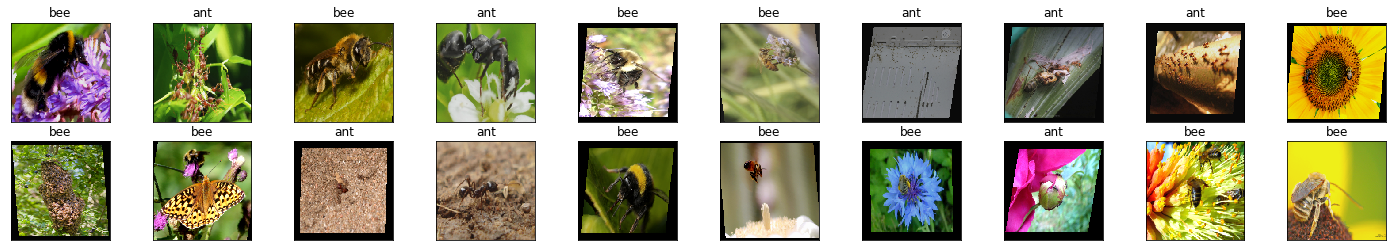

In [27]:
#the images look very ambiguous, dark and bright images. 
#ants and bees look really similar...
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [28]:
#going to use the AlexNet model
model = models.alexnet(pretrained=True)

In [29]:
print(model) #to see the model architecture 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

5 convolutional layers
3 fully connected layers. 
Relu applied at the convoluted and fully conected layers

Dropout applied before the 1st and 2nd fully connected layer. 

Now we need to freeze the parameters inside the feature extraction such that the convolutional layers will be unaffected by training. Keep the fully connected layers dynamic so we can learn which features are important. 

Freeze: 

In [30]:
#to freeze parameters 
for param in model.features.parameters():
    param.requires_grad = False #parameters unaffected by back propagation 
    #the output is also currently outputting 1000...but we only want 2 classes output
    

In [31]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features #get the 6th layer input features
#need to pass the input features into a new output layer
last_layer = nn.Linear(n_inputs, len(classes)) #2 classes
model.classifier[6] = last_layer #replaced the 6th layer with the last Layer
model.to(device)

print(model)
print(model.classifier[6].out_features)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 

In [33]:
#specifiy number of epochs
epochs = 10
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        # HERE IS WHERE WE NEED TO CHANGE THE ACCURACY BECAUSE OF BATCH SIZE CHANGE
        #training_loader.dataset, gives you a probability between 0 and 1, divide the correct predictions by the total number of images
        epoch_loss = running_loss/len(training_loader.dataset) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader.dataset) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0263, acc 0.7418
validation loss: 0.0178, validation acc 0.8954
epoch : 2
training loss: 0.0141, acc 0.8893
validation loss: 0.0198, validation acc 0.8693
epoch : 3
training loss: 0.0125, acc 0.9016
validation loss: 0.0233, validation acc 0.8366
epoch : 4
training loss: 0.0079, acc 0.9262
validation loss: 0.0151, validation acc 0.8889
epoch : 5
training loss: 0.0055, acc 0.9631
validation loss: 0.0144, validation acc 0.8889
epoch : 6
training loss: 0.0041, acc 0.9795
validation loss: 0.0139, validation acc 0.9020
epoch : 7
training loss: 0.0050, acc 0.9713
validation loss: 0.0165, validation acc 0.9150
epoch : 8
training loss: 0.0035, acc 0.9754
validation loss: 0.0184, validation acc 0.8954
epoch : 9
training loss: 0.0025, acc 0.9836
validation loss: 0.0185, validation acc 0.9085
epoch : 10
training loss: 0.0031, acc 0.9754
validation loss: 0.0153, validation acc 0.9085


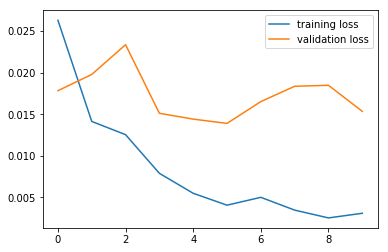

In [34]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

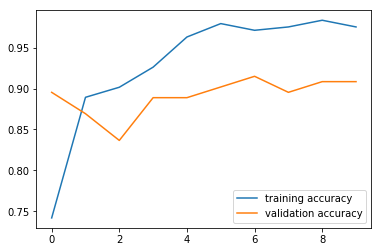

In [35]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

<Response [200]>


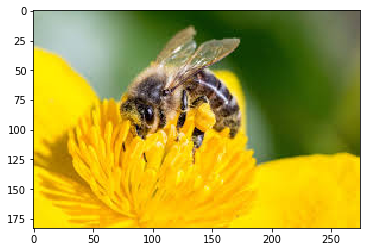

In [40]:
import requests #to grab an image
from PIL import Image #python imaging library
import PIL.ImageOps
#url = 'https://assets.weforum.org/article/image/iG2OW598YFc8CbNvjmHcMhYGzm4JwRAvPV7eUyUmT04.jpg'
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4uRJvCOICK2cFyuhFX5-LpWfoHXSNQrRuYw&usqp=CAU'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response) #successful get request

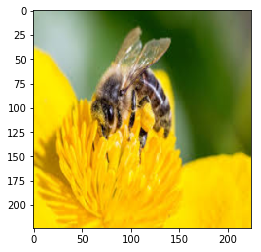

In [41]:
img = transform(img) #transforms and get a more abstracted 32x32 representation
plt.imshow(im_convert(img))

In [42]:
image = img.to(device).unsqueeze(0)
#The unsqueeze is to account for the extra layer of dimensionality
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


Able to effectively generalize to new images! And looks like it's not too bad with the validation set. 

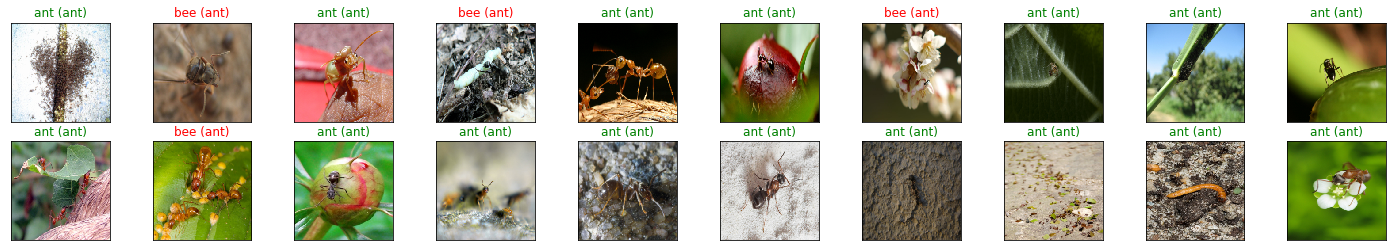

In [43]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))


#### VGG16

Let's try with the other model! 

In [69]:
#need to make sure all our data is 224x224 so it is compatible with the pre-trained model 
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))
                               ])
#random rotations seemed to have hindered the model previously 

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                               ])

#all ants in the first class, folder 0 class 0
#all bees in second class, folder 1, class 1
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

#changing the batch size because we have a smaller dataset (but we have to then change the accuracy for epoch below)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [70]:
def im_convert(tensor):
    #cannot convert cuda tensor to numpy. need cpa
    #so if using cuda use:
    # image = tensor.cpu().clone().detach().numpy()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [71]:
#only have 2 classes now, Ants class 0, bees class 1 (have to be in the right order)
classes = ('ant', 'bee')

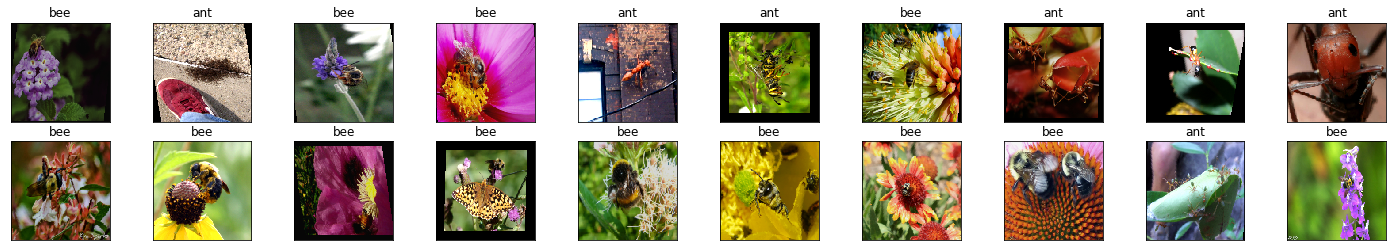

In [72]:
#the images look very ambiguous, dark and bright images. 
#ants and bees look really similar...
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [73]:
#going to use the VGG16 model
model = models.vgg16(pretrained=True)

#trained on gpu for 2-3 weeks! 

In [74]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [75]:
#to freeze parameters 
for param in model.features.parameters():
    param.requires_grad = False #parameters unaffected by back propagation 
    #the output is also currently outputting 1000...but we only want 2 classes output

In [76]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features #get the 6th layer input features
#need to pass the input features into a new output layer
last_layer = nn.Linear(n_inputs, len(classes)) #2 classes
model.classifier[6] = last_layer #replaced the 6th layer with the last Layer
model.to(device)

print(model)
print(model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 

In [78]:
#specifiy number of epochs
epochs = 2
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        # HERE IS WHERE WE NEED TO CHANGE THE ACCURACY BECAUSE OF BATCH SIZE CHANGE
        #training_loader.dataset, gives you a probability between 0 and 1, divide the correct predictions by the total number of images
        epoch_loss = running_loss/len(training_loader.dataset) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader.dataset) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0195, acc 0.7787
validation loss: 0.0133, validation acc 0.9150
epoch : 2
training loss: 0.0076, acc 0.9385
validation loss: 0.0189, validation acc 0.8954


From this, we see that it reaches a higher accruacy than Alex (VGG16 is a more sophisticated model). But it looks like there's overfitting (quite early on actually! ~1 epoch...) So running 10 epochs is too much. Let's just run 5 epochs instead. And then 2 epochs

But, it is probably better to change the data agumentation parameters. 

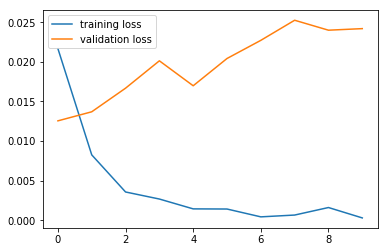

In [54]:
#10 epochs
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

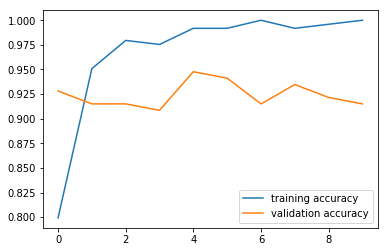

In [55]:
#10 epochs
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

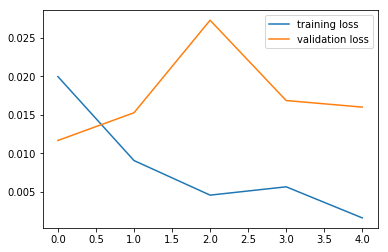

In [66]:
#5 epochs
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

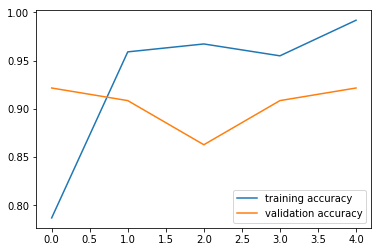

In [67]:
#5 epochs
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

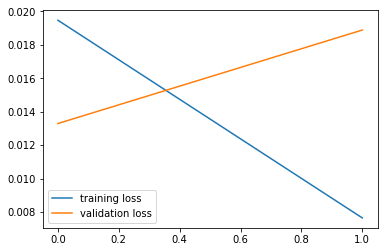

In [79]:
#2 epochs
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

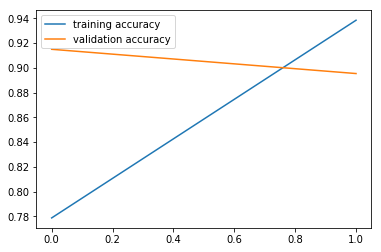

In [80]:
#2 epochs
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Transfer learning is useful when you don't have enough label training data to train the model from scratch. So harnessing the pre-trained model already that shown good performance on other tasks can save time and return good results too. 

<Response [200]>


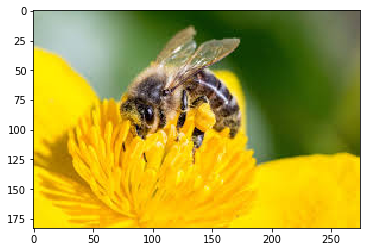

In [82]:
import requests #to grab an image
from PIL import Image #python imaging library
import PIL.ImageOps
#url = 'https://assets.weforum.org/article/image/iG2OW598YFc8CbNvjmHcMhYGzm4JwRAvPV7eUyUmT04.jpg'
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4uRJvCOICK2cFyuhFX5-LpWfoHXSNQrRuYw&usqp=CAU'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response) #successful get request

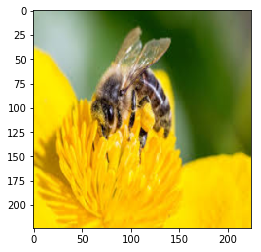

In [83]:
img = transform(img) #transforms and get a more abstracted 32x32 representation
plt.imshow(im_convert(img))

In [84]:
image = img.to(device).unsqueeze(0)
#The unsqueeze is to account for the extra layer of dimensionality
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


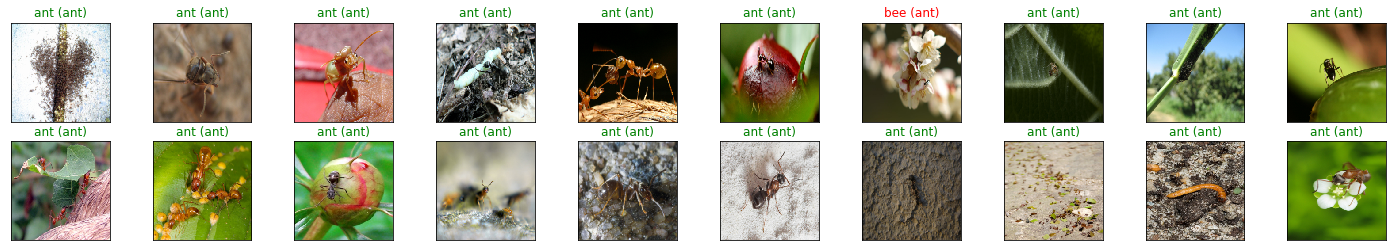

In [85]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
